# Лабораторная работа номер 4

Выполнил: Стрельцов Илья Дмитриевич Б9122-01.03.02мкт

## Импорты

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
SEED = 5

In [3]:
def plot_results(histories_dict, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for opt_name, history in histories_dict.items():
        plt.plot(history['train_loss'], label=f'{opt_name}')
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for opt_name, history in histories_dict.items():
        plt.plot(history['test_accuracy'], label=f'{opt_name}')
    plt.title(f'{title} - Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Подготовка данных

In [3]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=SEED
)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Нейронная сеть

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(
            self,
            input_size,
            dropout_rate=0.0
    ):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def train_model(
        optimizer,
        dropout_rate=0.0,
        epochs=50
):
    model = NeuralNetwork(input_size=X_train.shape[1], dropout_rate=dropout_rate)
    criterion = nn.BCELoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_preds = (test_outputs > 0.5).float()
            test_accuracy = accuracy_score(y_test_tensor.numpy(), test_preds.numpy())

        train_losses.append(total_loss / len(train_loader))
        test_accuracies.append(test_accuracy)

    return train_losses, test_accuracies, model

## Оптимизаторы (без Dropout)

In [13]:
models_no_dropout = {}
histories_no_dropout = {}

optimizers_config = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop
}

In [12]:
for opt_name, opt_class in optimizers_config.items():
    print(f"Training with {opt_name} (no dropout)")

    # Создаем модель и оптимизатор
    model = NeuralNetwork(input_size=X_train.shape[1], dropout_rate=0.0)

    optimizer = opt_class(model.parameters(), lr=0.001)

    criterion = nn.BCELoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(50):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_preds = (test_outputs > 0.5).float()
            test_accuracy = accuracy_score(y_test_tensor.numpy(), test_preds.numpy())

        train_losses.append(total_loss / len(train_loader))
        test_accuracies.append(test_accuracy)

    histories_no_dropout[opt_name] = {
        'train_loss': train_losses,
        'test_accuracy': test_accuracies
    }
    models_no_dropout[opt_name] = model

    print(f"{opt_name} - Final Test Accuracy: {test_accuracies[-1]:.4f}")

Training with SGD (no dropout)
SGD - Final Test Accuracy: 0.7800
Training with Adam (no dropout)
Adam - Final Test Accuracy: 0.9250
Training with RMSprop (no dropout)
RMSprop - Final Test Accuracy: 0.9400


## Исследование с Dropout

In [13]:
models_dropout = {}
histories_dropout = {}

In [14]:
for opt_name, opt_class in optimizers_config.items():
    print(f"Training with {opt_name} (with dropout)")

    model = NeuralNetwork(input_size=X_train.shape[1], dropout_rate=0.3)

    optimizer = opt_class(model.parameters(), lr=0.001)

    criterion = nn.BCELoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(50):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_preds = (test_outputs > 0.5).float()
            test_accuracy = accuracy_score(y_test_tensor.numpy(), test_preds.numpy())

        train_losses.append(total_loss / len(train_loader))
        test_accuracies.append(test_accuracy)

    histories_dropout[opt_name] = {
        'train_loss': train_losses,
        'test_accuracy': test_accuracies
    }
    models_dropout[opt_name] = model

    print(f"{opt_name} - Final Test Accuracy: {test_accuracies[-1]:.4f}")

Training with SGD (with dropout)
SGD - Final Test Accuracy: 0.6350
Training with Adam (with dropout)
Adam - Final Test Accuracy: 0.9300
Training with RMSprop (with dropout)
RMSprop - Final Test Accuracy: 0.9300


### Визуализация

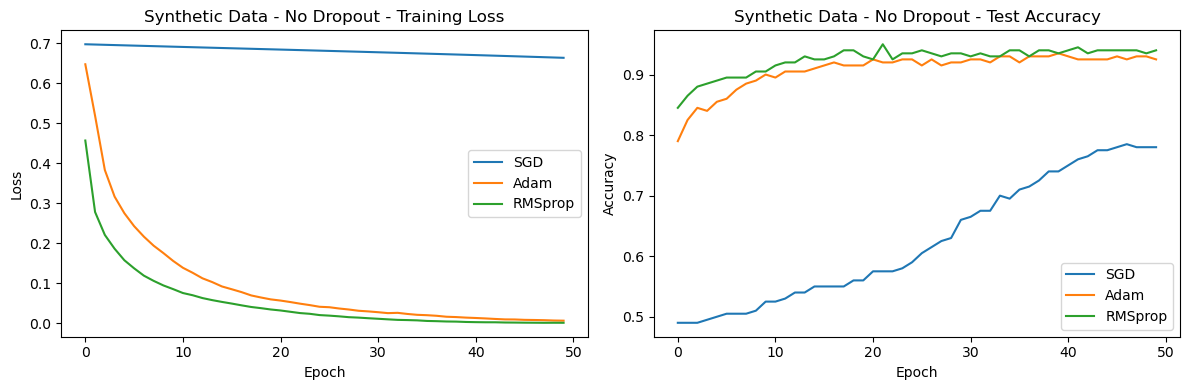

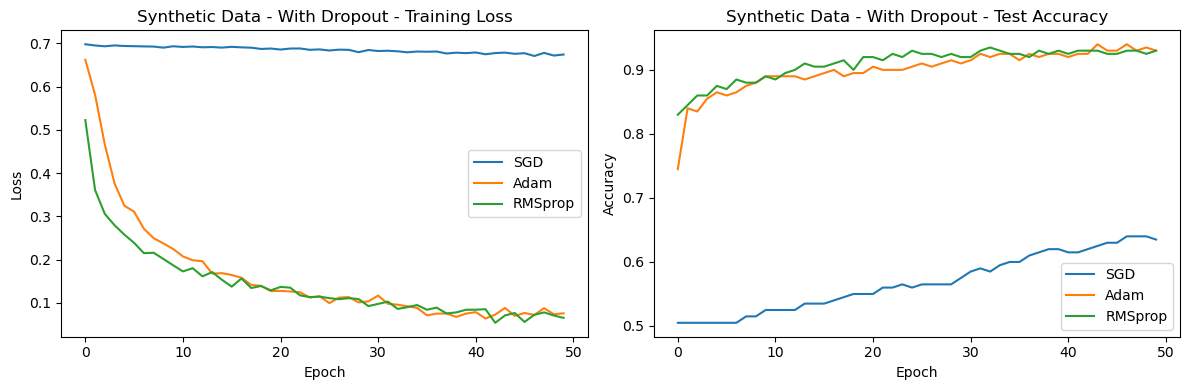

In [31]:
plot_results(histories_no_dropout, "Synthetic Data - No Dropout")
plot_results(histories_dropout, "Synthetic Data - With Dropout")

## MNIST

In [6]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [21]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(train_dataset)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.1307]), Std: tensor([0.3015])


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3015,))
])

optimizers_config = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop
}

In [7]:
train_dataset_mnist = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

In [8]:
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=128, shuffle=False)

In [9]:
class MNISTNetwork(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(MNISTNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [10]:
def train_mnist_model(optimizer, model, epochs=20):
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader_mnist:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader_mnist:
                outputs = model(batch_x)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        test_accuracy = correct / total
        train_losses.append(total_loss / len(train_loader_mnist))
        test_accuracies.append(test_accuracy)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader_mnist):.4f}, Accuracy: {test_accuracy:.4f}')

    return train_losses, test_accuracies

In [11]:
mnist_histories_no_dropout = {}
mnist_models_no_dropout = {}

In [15]:
for opt_name, opt_class in optimizers_config.items():
    print(f"Training MNIST with {opt_name} (no dropout)")

    model = MNISTNetwork(dropout_rate=0.0)

    optimizer = opt_class(model.parameters(), lr=0.001)

    train_losses, test_accuracies = train_mnist_model(optimizer, model, epochs=20)

    mnist_histories_no_dropout[opt_name] = {
        'train_loss': train_losses,
        'test_accuracy': test_accuracies
    }

    print(f"{opt_name} - Final Test Accuracy: {test_accuracies[-1]:.4f}")

Training MNIST with SGD (no dropout)
Epoch [5/20], Loss: 1.3985, Accuracy: 0.7629
Epoch [10/20], Loss: 0.6525, Accuracy: 0.8544
Epoch [15/20], Loss: 0.4785, Accuracy: 0.8796
Epoch [20/20], Loss: 0.4113, Accuracy: 0.8914
SGD - Final Test Accuracy: 0.8914
Training MNIST with Adam (no dropout)
Epoch [5/20], Loss: 0.0680, Accuracy: 0.9744
Epoch [10/20], Loss: 0.0387, Accuracy: 0.9787
Epoch [15/20], Loss: 0.0260, Accuracy: 0.9816
Epoch [20/20], Loss: 0.0198, Accuracy: 0.9802
Adam - Final Test Accuracy: 0.9802
Training MNIST with RMSprop (no dropout)
Epoch [5/20], Loss: 0.0731, Accuracy: 0.9702
Epoch [10/20], Loss: 0.0344, Accuracy: 0.9655
Epoch [15/20], Loss: 0.0234, Accuracy: 0.9800
Epoch [20/20], Loss: 0.0191, Accuracy: 0.9778
RMSprop - Final Test Accuracy: 0.9778


In [16]:
mnist_histories_dropout = {}
mnist_models_dropout = {}

In [17]:
for opt_name, opt_class in optimizers_config.items():
    print(f"Training MNIST with {opt_name} (with dropout)")

    model = MNISTNetwork(dropout_rate=0.3)

    optimizer = opt_class(model.parameters(), lr=0.001)

    train_losses, test_accuracies = train_mnist_model(optimizer, model, epochs=20)

    mnist_histories_dropout[opt_name] = {
        'train_loss': train_losses,
        'test_accuracy': test_accuracies
    }

    print(f"{opt_name} - Final Test Accuracy: {test_accuracies[-1]:.4f}")

Training MNIST with SGD (with dropout)
Epoch [5/20], Loss: 1.5929, Accuracy: 0.7456
Epoch [10/20], Loss: 0.8122, Accuracy: 0.8424
Epoch [15/20], Loss: 0.6032, Accuracy: 0.8717
Epoch [20/20], Loss: 0.5145, Accuracy: 0.8881
SGD - Final Test Accuracy: 0.8881
Training MNIST with Adam (with dropout)
Epoch [5/20], Loss: 0.1264, Accuracy: 0.9718
Epoch [10/20], Loss: 0.0912, Accuracy: 0.9770
Epoch [15/20], Loss: 0.0714, Accuracy: 0.9781
Epoch [20/20], Loss: 0.0672, Accuracy: 0.9800
Adam - Final Test Accuracy: 0.9800
Training MNIST with RMSprop (with dropout)
Epoch [5/20], Loss: 0.1384, Accuracy: 0.9721
Epoch [10/20], Loss: 0.0997, Accuracy: 0.9751
Epoch [15/20], Loss: 0.0834, Accuracy: 0.9778
Epoch [20/20], Loss: 0.0716, Accuracy: 0.9788
RMSprop - Final Test Accuracy: 0.9788


### Визуализация

In [18]:
def plot_mnist_results(histories_dict, title):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    for opt_name, history in histories_dict.items():
        plt.plot(history['train_loss'], label=f'{opt_name}')
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    for opt_name, history in histories_dict.items():
        plt.plot(history['test_accuracy'], label=f'{opt_name}')
    plt.title(f'{title} - Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    final_accuracies = [history['test_accuracy'][-1] for history in histories_dict.values()]
    optimizers = list(histories_dict.keys())
    plt.bar(optimizers, final_accuracies, color=['blue', 'orange', 'green'])
    plt.title(f'{title} - Final Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)

    for i, v in enumerate(final_accuracies):
        plt.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

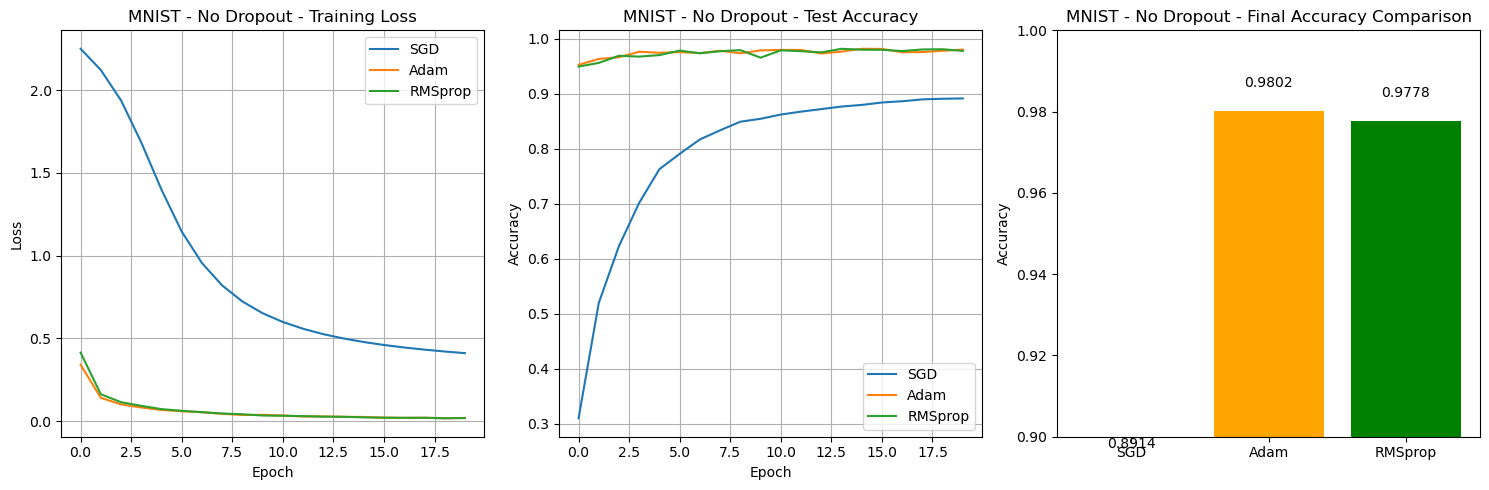

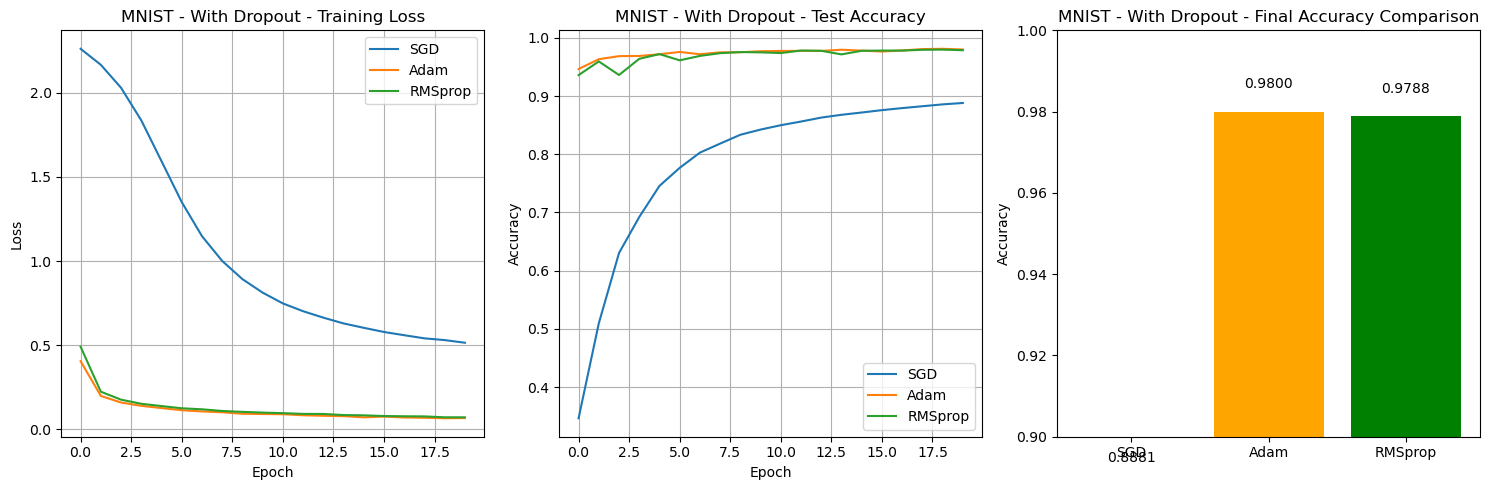

In [19]:
plot_mnist_results(mnist_histories_no_dropout, "MNIST - No Dropout")
plot_mnist_results(mnist_histories_dropout, "MNIST - With Dropout")